In [1]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve, log_loss

In [2]:
df_train = pd.read_csv('train.csv', sep=',').dropna(how="any").reset_index(drop=True)
df_train.shape

(404288, 6)

In [3]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df_train.tail()

,id,qid1,qid2,question1,question2,is_duplicate
404283,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404284,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404285,404287,537928,537929,What is one coin?,What's this coin?,0
404286,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404287,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


In [5]:
df_train_q1 = df_train.ix[:,'question1']
df_train_q1.head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
Name: question1, dtype: object

In [6]:
df_train_q2 = df_train.ix[:,'question2']
df_train_q2.head()

0    What is the step by step guide to invest in sh...
1    What would happen if the Indian government sto...
2    How can Internet speed be increased by hacking...
3    Find the remainder when [math]23^{24}[/math] i...
4              Which fish would survive in salt water?
Name: question2, dtype: object

In [7]:
count_vect = CountVectorizer(min_df=1, 
                             max_features=2000, 
                             analyzer='char', 
                             ngram_range=(1,2), 
                             binary=True, 
                             stop_words='english')

# real parameters are: min_df=30, max_features=2000000, ngram_range=(1,9)
# computing with real parameters takes a lot of memory!!

In [8]:
count_vect.fit(pd.concat((df_train_q1,df_train_q2)))

CountVectorizer(analyzer='char', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [9]:
count_vect_matr_q1_train = count_vect.transform(df_train_q1)
count_vect_matr_q2_train = count_vect.transform(df_train_q2)

In [10]:
X_train = -(count_vect_matr_q1_train != count_vect_matr_q2_train).astype(int)
y_train = np.array(df_train.ix[:,'is_duplicate'])

In [11]:
clf = LogisticRegression(class_weight={0: 1.309, 1: 0.472})
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 1.309, 1: 0.472}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [12]:
count_feature_names_sorted = [count_vect.get_feature_names()[i] for i in np.argsort(clf.coef_)[0]]

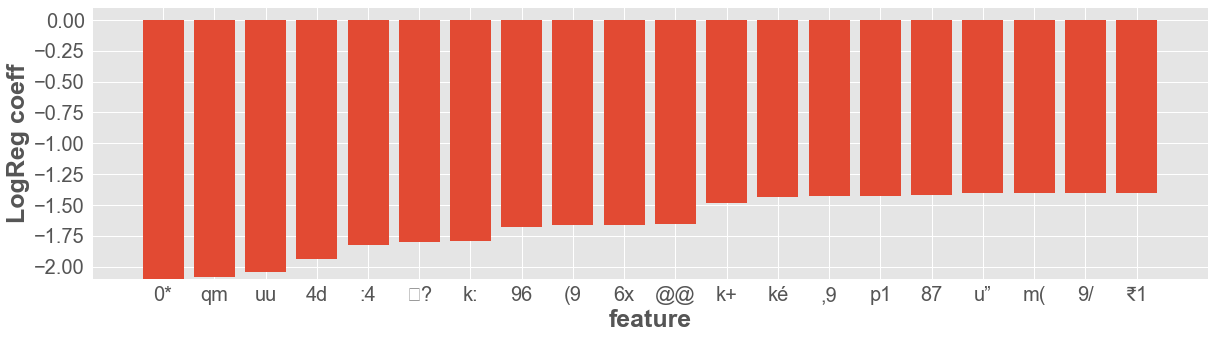

In [13]:
max_features = 20
letters = count_feature_names_sorted[:max_features]
coefs = np.sort(clf.coef_)[0][:max_features]

plt.figure()
fig = plt.figure(figsize=(max_features,5))
ax = fig.add_subplot(111)

x_coordinates = np.arange(len(letters))
ax.bar(x_coordinates, coefs, align='center')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
ax.xaxis.set_major_locator(plt.FixedLocator(x_coordinates))
ax.xaxis.set_major_formatter(plt.FixedFormatter(letters))
plt.xlabel('feature', fontsize=25, fontweight='bold')
plt.ylabel('LogReg coeff', fontsize=25, fontweight='bold')

plt.show()

roc_auc =  0.826264187577 
log_loss =  0.566735668792


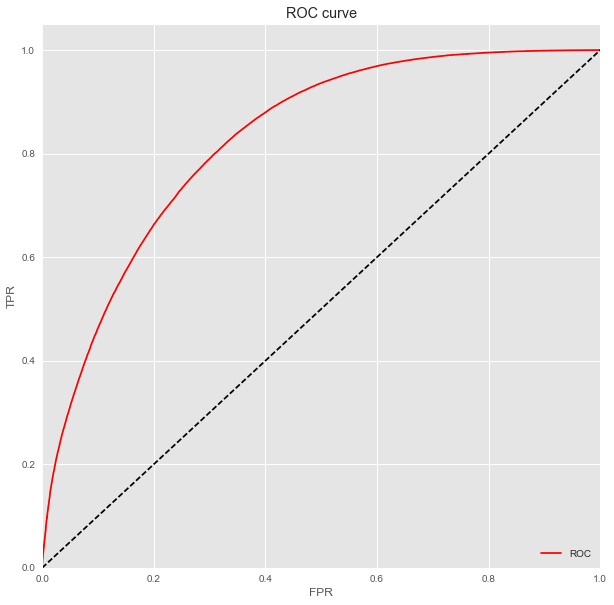

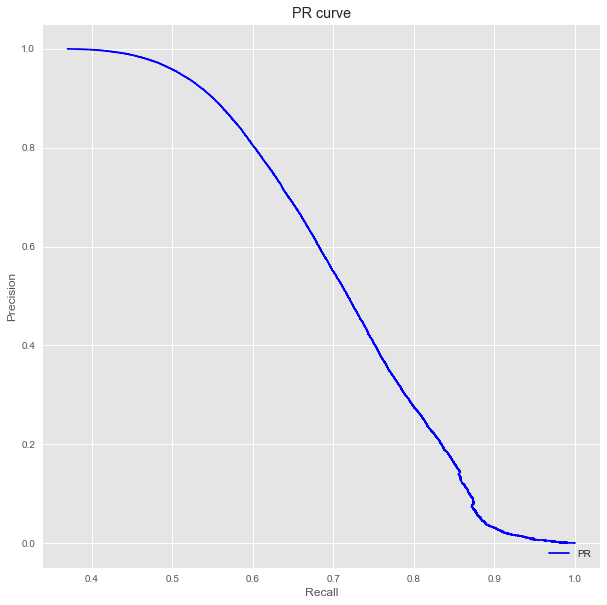

In [14]:
y_score = clf.predict_proba(X_train)[:,1]
fpr, tpr, _ = roc_curve(y_train, y_score)
roc_auc = auc(fpr, tpr)
logloss = log_loss(y_train, y_score)

print 'roc_auc = ', roc_auc, '\nlog_loss = ', logloss

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

pr, re, _ = precision_recall_curve(y_train, y_score)
plt.figure(figsize=(10,10))
plt.plot(pr, re, color='blue', label='PR')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(loc="lower right")
plt.show()

In [15]:
df_test = pd.read_csv('test.csv', sep=',').fillna("")

In [16]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [17]:
df_test.tail()

,test_id,question1,question2
2345791,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?
2345792,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?
2345793,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?
2345794,2345794,What were the best and worst things about publ...,What are the best and worst things examination...
2345795,2345795,What is the best medication equation erectile ...,How do I out get rid of Erectile Dysfunction?


In [18]:
df_test_q1 = df_test.ix[:,'question1']
df_test_q1.head()

0    How does the Surface Pro himself 4 compare wit...
1    Should I have a hair transplant at age 24? How...
2    What but is the best way to send money from Ch...
3                          Which food not emulsifiers?
4                     How "aberystwyth" start reading?
Name: question1, dtype: object

In [19]:
df_test_q2 = df_test.ix[:,'question2']
df_test_q2.head()

0    Why did Microsoft choose core m3 and not core ...
1          How much cost does hair transplant require?
2                        What you send money to China?
3                                    What foods fibre?
4                       How their can I start reading?
Name: question2, dtype: object

In [20]:
count_vect_matr_q1_test = count_vect.transform(df_test_q1)
count_vect_matr_q2_test = count_vect.transform(df_test_q2)

In [21]:
X_test = -(count_vect_matr_q1_test != count_vect_matr_q2_test).astype(int)

In [22]:
y_test = clf.predict_proba(X_test)[:,1]

In [23]:
df_res = pd.DataFrame()
df_res['test_id'] = df_test['test_id']
df_res['is_duplicate'] = y_test
df_res.to_csv('output.csv', index=False)